## Switched Unit conventions in `RealSim-IFS`

Having the fiber properties defined in mm is not useful, in hindsight. Much better to define things in on-sky units.

In [1]:
import os,sys,time
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from shutil import copy as cp
from glob import glob
import RealSim_IFS

In [2]:

if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
    wdir = os.environ['SLURM_TMPDIR']
    os.chdir(wdir)
    print(os.getcwd())

/localscratch/bottrell.37265873.0


## Testing application of `RealSim_IFS` to a TNG100-1 post-merger

Below, I show the idealized stellar surface density, velocity, and velocity dispersion maps for a TNG100-1 post-merger in 4 camera angles. Note how the observed rotation is highly sensitive to the viewing angle.

/localscratch/bottrell.36802841.0
/project/6020225/bottrell/share/mhani/LOSVD/losvd_TNG100-1_99_404216_stars_i0__32.fits
4.7990734577178955
/project/6020225/bottrell/share/mhani/LOSVD/losvd_TNG100-1_99_404319_stars_i0__32.fits
4.008834600448608
/project/6020225/bottrell/share/mhani/LOSVD/losvd_TNG100-1_99_404501_stars_i0__32.fits
4.1503214836120605
/project/6020225/bottrell/share/mhani/LOSVD/losvd_TNG100-1_99_427314_stars_i0__32.fits
4.499385833740234


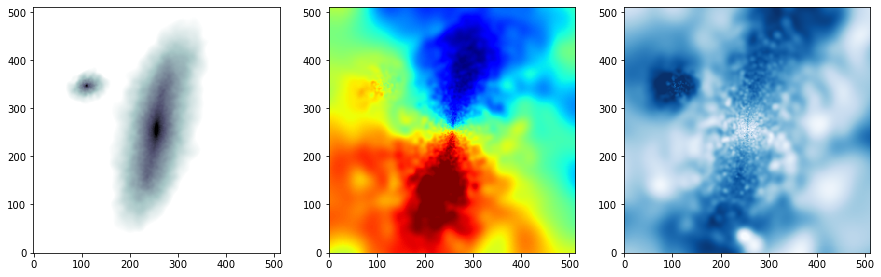

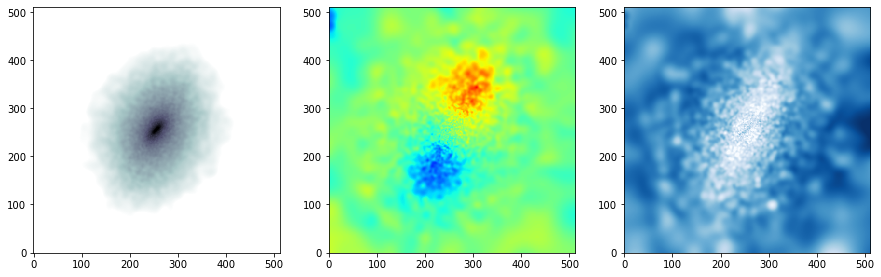

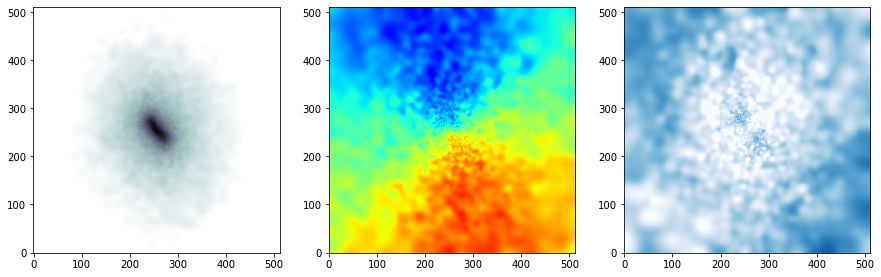

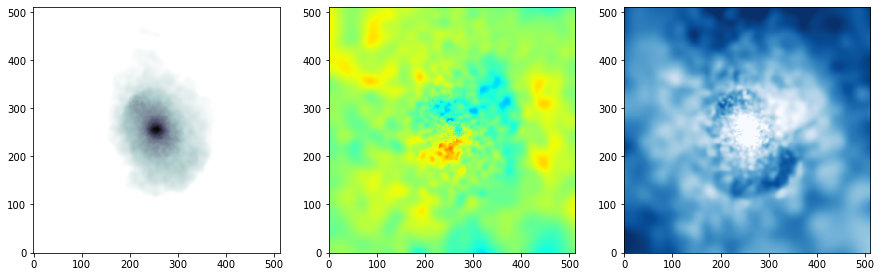

In [9]:
def main():
    
    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
        print(os.getcwd())
        
    losvd_dir = '/project/6020225/bottrell/share/mhani/LOSVD'
    filenames = list(sorted(glob('{}/*stars_i0*__32.fits'.format(losvd_dir))))
    
    
    for filename in filenames[4:8]:
        print(filename)
        start = time.time()
        localfile = filename.replace(losvd_dir,wdir)
        start = time.time()
        cp(filename,localfile)
        maps = RealSim_IFS.Generate_Maps_From_File(localfile)
        print(time.time()-start)
        if os.access(localfile,0):os.remove(localfile)
            
        fig,axarr = plt.subplots(1,3,figsize=(15,5))
        ax = axarr[0]
        ax.imshow(np.log10(maps[0]),vmin=5,vmax=8,cmap='bone_r',origin='lower')
        ax = axarr[1]
        ax.imshow(maps[1],cmap='jet_r',vmin=-175,vmax=175,origin='lower')
        ax = axarr[2]
        ax.imshow(maps[2],cmap='Blues_r',vmin=50,vmax=150,origin='lower')
    
if __name__ == '__main__':
    main()

## Generate obserivng pattern

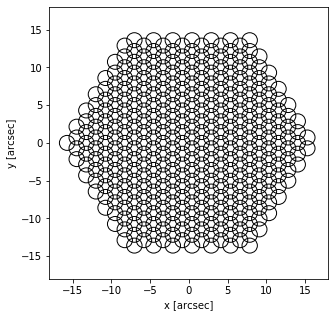

In [4]:
import importlib
importlib.reload(RealSim_IFS)
from matplotlib.patches import Circle

(xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='N127',
                                                   n_observations='Classic',
                                                   rotation_degrees = 0.,
                                                   return_params=True)

core_diameter_arcsec = params['core_diameter_arcsec']

fig,ax = plt.subplots(figsize=(5,5))
    
for xy in zip(xc_arr.flat,yc_arr.flat):
    core = Circle(xy=xy,radius=core_diameter_arcsec/2,transform=ax.transData,edgecolor='Black',facecolor='None')
    ax.add_artist(core)
    ax.set_xlim(-18,18)
    ax.set_ylim(-18,18)
    ax.set_xlabel('x [arcsec]')
    ax.set_ylabel('y [arcsec]')

## Choose one galaxy (orientation) to observe

Show header keywords for FOV and dimensions.

In [3]:
wdir = os.environ['SLURM_TMPDIR']
losvd_dir = '/project/6020225/bottrell/share/mhani/LOSVD'

filename = '{}/losvd_TNG100-1_99_404216_stars_i0__32.fits'.format(losvd_dir)
localfile = filename.replace(losvd_dir,wdir)
start = time.time()
cp(filename,localfile)

hdr = fits.getheader(filename)
print(hdr)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  300                                                  NAXIS2  =                  512                                                  NAXIS3  =                  512                                                  EXTEND  =                    T                                                  PARTTYPE= 'stars   '           / particle type in maps                          AXIS    = 'i0      '           / instrument                                     FOVSIZE =                   10 / FOV size                                       FOVUNIT = 'rhalf   '           / FOV size units                                 FOV_KPC =    107.9381304150456 / [kpc]                                          NPIXEL  =                  512 / spatial

Note `FOVUNIT` is `rhalf` and that `FOVSIZE` is 10, meaning that the FOV diameter is 10 half stellar mass radii (physical). The `FOV_KPC` is also given along with the total number of pixels, `NPIXEL` in each spatial dimension. 

## Examine MaNGA sample selection

We want a similar redshift distribution to the MaNGA sample. But we can also generate synthetic data of each simulated galaxy at multiple redshifts. Therefore, each galaxy can be observed as though it was in the primary sample, secondary sample. Instead of splitting into primary and secondary, however, I could pick 5 redshifts for each galaxy so that they may be observed with each of the 5 IFU designs out to $1.5 R_e$ and then 5 more to be observed out to $2.5 R_e$.

Text(0, 0.5, 'Redshift, z')

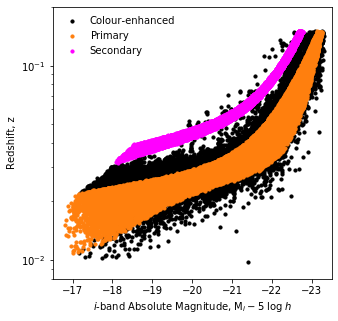

In [5]:
targetcat_name = 'MaNGA_targets_extNSA_tiled_ancillary.fits'
if not os.access(targetcat_name,0):
    targetcat_url = 'https://data.sdss.org/sas/dr16/manga/target/v1_2_27/{}'.format(targetcat_name)
    os.system('wget {}'.format(targetcat_url))

data = fits.getdata(targetcat_name)
bitmask = data['MANGA_TARGET1']
pri_mask = (bitmask & 1024)!=0
sec_mask = (bitmask & 2048)!=0
cen_mask = (bitmask & 4096)!=0

# queued to be observed
obsflag = data['OBSFLAG']==1
# selected by random generator
ranflag = data['RANFLAG']==1

pri = data[pri_mask]
sec = data[sec_mask]
cen = data[cen_mask]

fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(cen['NSA_ELPETRO_ABSMAG'][:,5],cen['NSA_Z'],s=10,c='black',label='Colour-enhanced')
ax.scatter(pri['NSA_ELPETRO_ABSMAG'][:,5],pri['NSA_Z'],s=10,c='C1',label='Primary')
ax.scatter(sec['NSA_ELPETRO_ABSMAG'][:,5],sec['NSA_Z'],s=10,c='magenta',label='Secondary')
ax.legend(frameon=False)
ax.set_yscale('log')
ax.set_ylim(8e-3,2e-1)
ax.set_xlim(-16.5,-23.5)
ax.set_xlabel(r'$i$-band Absolute Magnitude, M$_i - 5\;\log \;h$')
ax.set_ylabel(r'Redshift, z')

## Redshift distribution

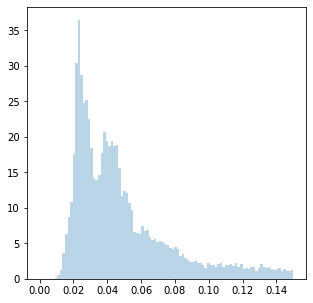

In [6]:
redshifts_pri = pri['NSA_Z']
redshifts_sec = sec['NSA_Z']
redshifts_cen = cen['NSA_Z']

redshifts = np.concatenate([redshifts_pri,redshifts_sec,redshifts_cen])

fig,ax=plt.subplots(figsize=(5,5))

def hist(ax,zs,c='black'):
    xedges = np.linspace(0,0.15,101,endpoint=True)
    widths = (xedges[1:]-xedges[:-1])
    xcs = xedges[:-1]+widths/2.
    H,xedges=np.histogram(zs,bins=xedges)
    PDF = H/np.sum(H)/widths
    ax.bar(x=xcs,height=H/np.sum(H)/widths,width=widths,alpha=0.3,color=c)
    
# hist(ax,redshifts_pri,c='C1')
# hist(ax,redshifts_sec,c='magenta')
# hist(ax,redshifts_cen,c='black')

hist(ax,redshifts,c='C0')



## Create tables from which to draw insertion statistics

These tables should include the objIDs, redshifts, run, rerun, camcol, and field values for all of the MaNGA selection candidates in the table above. The redshifts can be drawn from the catalogue above. The objIDs, run, rerun, camcol, field values can be drawn from the SDSS spectroscopic sample for ease. Ultimately, the MaNGA sample is drawn from this parent sample without priors on field statistics. Therefore, selecting field statistics from this parent sample is justified.

Need half-stellar mass radii in headers for determining which IFU design to assign.

## Redshift table

In [31]:
targetcat_name = 'MaNGA_targets_extNSA_tiled_ancillary.fits'
if not os.access(targetcat_name,0):
    targetcat_url = 'https://data.sdss.org/sas/dr16/manga/target/v1_2_27/{}'.format(targetcat_name)
    os.system('wget {}'.format(targetcat_url))

data = fits.getdata(targetcat_name)
bitmask = data['MANGA_TARGET1']
pri_mask = (bitmask & 1024)!=0
sec_mask = (bitmask & 2048)!=0
cen_mask = (bitmask & 4096)!=0

# full manga sample
manga_all = data[(pri_mask+sec_mask+cen_mask)>=1]

# print(manga_all['IFUTARGETSIZE'])
# print(manga_all['IFUDESIGNSIZE'])
# print(manga_all['NSA_ELPETRO_TH50_R']*1.5*2)

catalog_name = 'MaNGA_target_redshifts-all.txt'
np.savetxt(catalog_name,manga_all['NSA_Z'])
cp(catalog_name,'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources')


'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources/MaNGA_target_redshifts-all.txt'

## Create table to draw SDSS photometry statistics

Take SDSS DR7 spectroscopic sample field info. Redshifts can be drawn independently from the table above.

In [59]:
import pymysql
import numpy as np

cnf_path = '/home/bottrell/.mysql/lauca.cnf'
db = pymysql.connect(host='lauca.phys.uvic.ca',
                     user='cbottrell',
                     database='sdss',
                     read_default_file=cnf_path)
c = db.cursor()
dbcmd = ['SELECT f.objID,f.run,f.rerun,f.camcol,f.field',
         'FROM dr7_uberuber as u JOIN dr7_field_info as f',
         'ON u.objID=f.objID',
         'WHERE u.specclass=2']
c.execute(' '.join(dbcmd))
data = np.asarray(c.fetchall())
c.close()
db.close()
objIDs = data[:,0].astype(int)
runs = data[:,1].astype(int)
reruns = data[:,2].astype(int)
camcols = data[:,3].astype(int)
fields = data[:,4].astype(int)

data = zip(objIDs,runs,reruns,camcols,fields)
data = np.array(list(data),dtype=[('OBJID', 'i8'), ('RUN', 'i4'), ('RERUN', 'i4'), ('CAMCOL','i4'),('FIELD','i4')])
outfile = 'SDSS_DR7_SPEC_FIELD_INFO.npy'
np.save(outfile,data)
cp(outfile,'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources')

'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources/SDSS_DR7_SPEC_FIELD_INFO.npy'

## Select a redshift at which to observe this object

The median redshift of MaNGA is roughly $z=0.046$ according to the `dr15_manga_pipe3d` table on our local database on the lauca server (z_VAC).

107.9381304150456
1.84116
0.08812185376882553
1130.094298362732
FOV arcsec 63.1406929924782
6.31406929924782


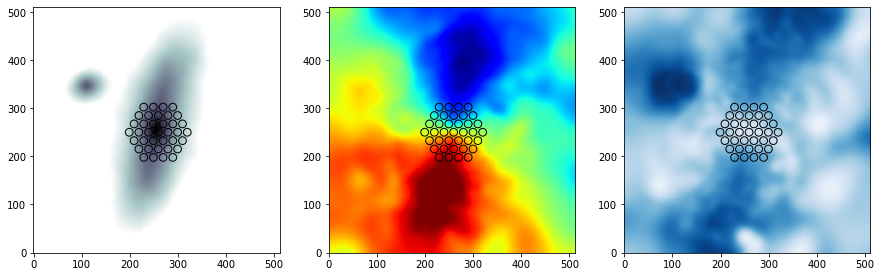

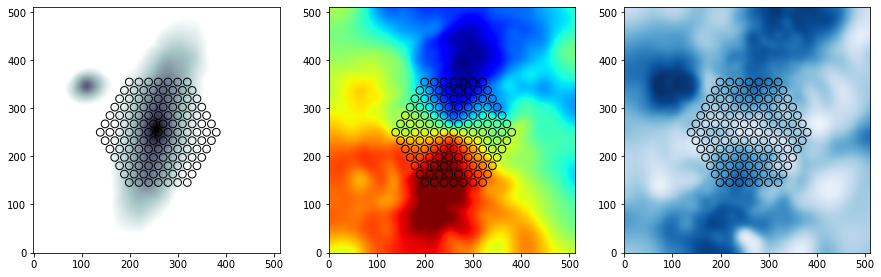

In [29]:
import importlib 
importlib.reload(RealSim_IFS)

from astropy.cosmology import FlatLambdaCDM
from astropy.convolution import convolve
import multiprocessing
import gc
    
def plot(filename,datacube):
    maps = RealSim_IFS.Generate_Maps_From_Data(filename,datacube)
    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    ax = axarr[0]
    ax.imshow(np.log10(maps[0]),vmin=5,vmax=8,cmap='bone_r',origin='lower')
    ax = axarr[1]
    ax.imshow(maps[1],cmap='jet_r',vmin=-175,vmax=175,origin='lower')
    ax = axarr[2]
    ax.imshow(maps[2],cmap='Blues_r',vmin=50,vmax=150,origin='lower')
    return fig,axarr

def overlay_ifu_design(fig,axarr,datacube,arcsec_per_pixel,manga_ifu_design='N127'):
    (xc_arcsec,yc_arcsec),params = RealSim_IFS.MaNGA_Observe(bundle_name=manga_ifu_design,
                                                   n_observations='Classic',
                                                   rotation_degrees = 0.,
                                                   return_params=True)
    core_diameter_arcsec = params['core_diameter_arcsec']
    xc_pixels = xc_arcsec/arcsec_per_pixel+datacube.shape[2]/2.
    yc_pixels = yc_arcsec/arcsec_per_pixel+datacube.shape[1]/2.
    core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel
    for ax in axarr.flat:
        for xy in zip(xc_pixels[:,0],yc_pixels[:,0]):
            core = Circle(xy=xy,radius=core_diameter_pixels/2,transform=ax.transData,edgecolor='Black',facecolor='None')
            ax.add_artist(core)
    return fig,axarr

def main(sim_tag,snapID,subhaloID,camera,ptype):
    
    cosmo=FlatLambdaCDM(H0=67.4,Om0=0.315)
    wdir = os.environ['SLURM_TMPDIR']

    filename = 'losvd_{}_{}_{}_{}_i{}__32.fits'.format(sim_tag,snapID,subhaloID,ptype,camera)
    if not os.access('{}/{}'.format(wdir,filename),0):
        losvd_dir = '/project/6020225/bottrell/share/mhani/LOSVD'
        cp('{}/{}'.format(losvd_dir,filename),wdir)

    datacube = np.transpose(fits.getdata(filename),[2,0,1])
    hdr = fits.getheader(filename)

    # physical spatial pixel scale in datacube
    kpc_per_pixel = hdr['FOV_KPC']/hdr['NPIXEL']
    
    print(hdr['FOV_KPC'])
    # The FOVSIZE keyword gives the size of the FOV in
    # units of FOVUNIT (in this case, stellar half-mass radii)
    R_eff_kpc = hdr['FOV_KPC']/hdr['FOVSIZE']

    seed = 94182812
    seeing_fwhm_arcsec = RealSim_IFS.get_random_seeing_manga(seed=seed)
    redshift = RealSim_IFS.get_random_redshift_manga(seed=seed)
    print(seeing_fwhm_arcsec)
    print(redshift)

    start = time.time()
    outcube = RealSim_IFS.apply_seeing(datacube=datacube,kpc_per_pixel=kpc_per_pixel,redshift=redshift,
                                       seeing_fwhm_arcsec=seeing_fwhm_arcsec,seeing_model='manga',
                                       use_threading=False,n_threads=1,cosmo=cosmo)
    print(time.time()-start)
    
    # pick ifu for target
    manga_ifu_designs = np.array(['N19','N37','N61','N91','N127'])
    manga_ifu_diameters_arcsec = np.array([12.5,17.5,22.5,27.5,32.5]) # [arcsec]
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
    arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec
    print('FOV arcsec', hdr['FOV_KPC']/kpc_per_arcsec)
    
    R_eff_arcsec = R_eff_kpc / kpc_per_arcsec # [arcsec]
    
    # primary ifu design
    primary_sample_arg = np.argmin(np.abs(2*1.5*R_eff_arcsec-manga_ifu_diameters_arcsec))
    primary_design = manga_ifu_designs[primary_sample_arg]
    
    # secondary ifu design
    secondary_sample_arg = np.argmin(np.abs(2*2.5*R_eff_arcsec-manga_ifu_diameters_arcsec))
    secondary_design = manga_ifu_designs[secondary_sample_arg]
    
    for manga_ifu_design in [primary_design,secondary_design]:
        # plot maps
        fig,axarr = plot(filename,outcube)
        # primary sample ifu design overlay
        fig,axarr = overlay_ifu_design(fig,axarr,outcube,arcsec_per_pixel,manga_ifu_design=manga_ifu_design)

    
if __name__ == '__main__':
    
    gc.collect()
    
    sim_tag='TNG100-1'
    snapID = 99
    subhaloID = 404216
    camera = 0
    ptype = 'stars'
    
    main(sim_tag,snapID,subhaloID,camera,ptype)
    
     

/localscratch/bottrell.37265873.0


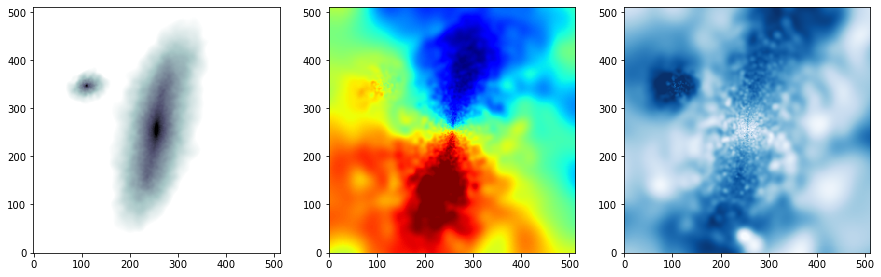

In [3]:
import os
import numpy as np
from astropy.io import fits

def generate_maps_losvdcube(losvd_data,vlim=700.):
    '''Compute moment maps for an LOSVD cube of shape (spatial_xels,spatial_yels,vels) where vels is the number of velocity elements. The velocity elements must be symmetric about zero with range [vlim,vlim] in km/s.'''
    vel = np.linspace(-vlim,vlim,losvd_data.shape[-1],endpoint=False)
    delv = 2*vlim/losvd_data.shape[-1]
    vel+=delv/2.
    sum_wi = np.nansum(losvd_data,axis=-1)
    sum_wivi = np.nansum(losvd_data*vel,axis=-1)
    vbar = sum_wivi/sum_wi
    Nprime = np.nansum(losvd_data>0,axis=-1)
    vstd = np.nansum(losvd_data*(vel-vbar[...,np.newaxis])**2,axis=-1)
    vstd /= (Nprime-1)/Nprime*sum_wi
    vstd = np.sqrt(vstd)
    losvd_maps = np.array([sum_wi,vbar,vstd])
    return losvd_maps 

def write_maps_to_fits(outname,losvd_maps,header):
    '''Write LOSVD moment maps to FITS file `outname` with primary header `header`.'''
    if os.access(outname,0): os.remove(outname)
    hdu_pri = fits.PrimaryHDU(losvd_maps)
    hdu_pri.header = header
    # !!! IF NOT ALREADY IN `header`, ADD ALL THE LOSVD HEADER KEYWORDS HERE !!! e.g.
    # header.append(('AUTHOR', 'MAAN HANI'),end=True)
    hdu_pri.writeto(outname)

def plot(maps):
    '''Plot maps.'''
    import matplotlib.pyplot as plt
    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    ax = axarr[0]
    ax.imshow(np.log10(maps[0]),vmin=5,vmax=8,cmap='bone_r',origin='lower')
    ax = axarr[1]
    ax.imshow(maps[1],cmap='jet_r',vmin=-175,vmax=175,origin='lower')
    ax = axarr[2]
    ax.imshow(maps[2],cmap='Blues_r',vmin=50,vmax=150,origin='lower')
    return fig,axarr

def main():
    
    from shutil import copy as cp

    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
        print(os.getcwd())
    
    simID = 'TNG100-1'
    snapID = 99
    subhaloID = 404216
    parttype = 'stars'
    camera = 0

    losvd_dir = '/project/6020225/bottrell/share/mhani/LOSVD'
    filename = 'losvd_{}_{}_{}_{}_i{}__32.fits'.format(simID,snapID,subhaloID,parttype,camera)
    if not os.access(filename,0):
        remote_filepath = '{}/{}'.format(losvd_dir,filename)
        cp(remote_filepath,wdir)

    datacube = fits.getdata(filename)
    hdr = fits.getheader(filename)
    vlim = hdr['VLIM']
    
    # generate maps from datacube (need vlim)
    maps = generate_maps_losvdcube(datacube,vlim=vlim)
    
    # name of output losvd moments fits file
    outname = '{}/moments_{}_{}_{}_{}_i{}__32.fits'.format(wdir,simID,snapID,subhaloID,parttype,camera)
    
    # write to fits file
    write_maps_to_fits(outname,maps,hdr)

    # plot results from file
    maps = fits.getdata(outname)
    fig,axarr = plot(maps)
    
if __name__ == '__main__':
    main()
